In [100]:
import torch

# Check the PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# Check why CUDA is not available 
if cuda_available:
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA not available")


PyTorch version: 2.4.0
CUDA available: False
CUDA not available


# Import Libraries

In [102]:
import os
import numpy as np
import pandas as pd
import cv2
import random
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Define Paths

In [104]:
data_dir = r"C:\Users\User\OneDrive\Desktop\AV Lab\logging6\logging"
log_file_path = os.path.join(data_dir, "logging_data", "log_file_0.txt")
image_base_path = os.path.join(data_dir, "image_data")

# Verify the paths
print(f"Log file path: {log_file_path}")
print(f"Image base path: {image_base_path}")

#image_base_path = r'C:\Users\User\OneDrive\Desktop\AV Lab\logging6\logging\image_data'





Log file path: C:\Users\User\OneDrive\Desktop\AV Lab\logging6\logging\logging_data\log_file_0.txt
Image base path: C:\Users\User\OneDrive\Desktop\AV Lab\logging6\logging\image_data


# Verify the Image Files

In [106]:
# List the first few images in the directory
image_files = os.listdir(image_base_path)
for i, image_file in enumerate(image_files[:33]): 
    print(f"{i+1}: {image_file}")



1: image_front_1.jpg
2: image_front_10.jpg
3: image_front_100.jpg
4: image_front_1000.jpg
5: image_front_1001.jpg
6: image_front_1002.jpg
7: image_front_1003.jpg
8: image_front_1004.jpg
9: image_front_1005.jpg
10: image_front_1006.jpg
11: image_front_1007.jpg
12: image_front_1008.jpg
13: image_front_1009.jpg
14: image_front_101.jpg
15: image_front_1010.jpg
16: image_front_1011.jpg
17: image_front_1012.jpg
18: image_front_1013.jpg
19: image_front_1014.jpg
20: image_front_1015.jpg
21: image_front_1016.jpg
22: image_front_1017.jpg
23: image_front_1018.jpg
24: image_front_1019.jpg
25: image_front_102.jpg
26: image_front_1020.jpg
27: image_front_1021.jpg
28: image_front_1022.jpg
29: image_front_1023.jpg
30: image_front_1024.jpg
31: image_front_1025.jpg
32: image_front_1026.jpg
33: image_front_1027.jpg


# Read and Process Log File

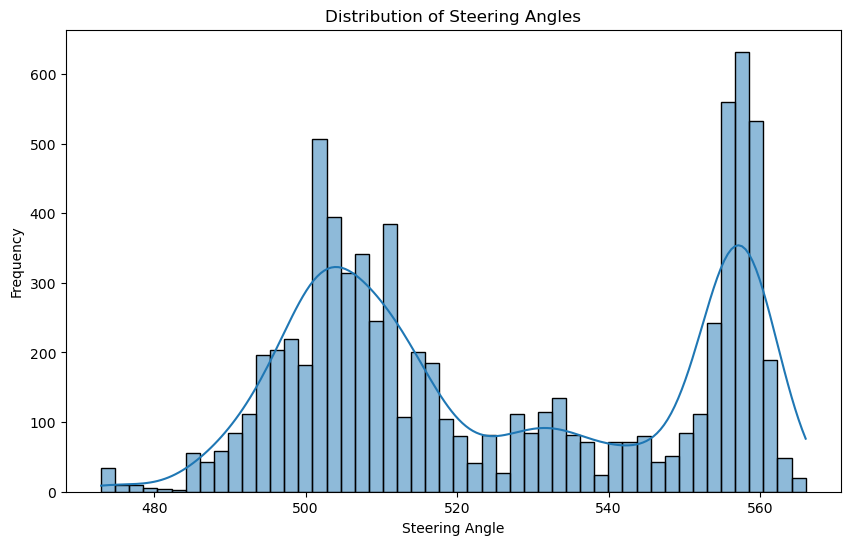

In [108]:
# Read the log file content
with open(log_file_path, 'r') as file:
    log_file_content = file.read()

# Process the log file content
log_lines = log_file_content.strip().split('\n')
data = []
skipped_lines = 0

for line in log_lines:
    parts = line.split()
    if len(parts) == 5 and parts[0] != 'Time':
        front_image = parts[1]
        left_image = parts[2]
        right_image = parts[3]
        steering_angle = float(parts[4])
        data.append([front_image, left_image, right_image, steering_angle])
    else:
        skipped_lines += 1

# Create a pandas DataFrame
df = pd.DataFrame(data, columns=['Front Image', 'Left Image', 'Right Image', 'Steering Angle'])

# Drop rows with indices ranging from 4230 to 4814
#df.drop(df.index[:6], inplace=True)
#df.drop(df.index[4230:4815], inplace=True)

# Reset the index
df.reset_index(drop=True, inplace=True)

# Display the DataFrame
#print(df.head())
#print(df.tail())


# Plot the distribution of the "Steering Angle" column
plt.figure(figsize=(10, 6))
sns.histplot(df['Steering Angle'], bins=50, kde=True)  
plt.title('Distribution of Steering Angles')
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.show()



# Normalizing and Standardising the Steering angles


In [110]:
steering_angles = df['Steering Angle'].values  

# Normalization (to [-1, 1])
scaler = MinMaxScaler(feature_range=(-1, 1))
steering_angles = scaler.fit_transform(steering_angles.reshape(-1, 1))

# Standardization (Z-score scaling)
standardizer = StandardScaler()
steering_angles = standardizer.fit_transform(steering_angles)

# Update the DataFrame
df['Steering Angle'] = steering_angles

print(df.head())


                                        Front Image  \
0  /home/admin/logging/image_data/image_front_1.jpg   
1  /home/admin/logging/image_data/image_front_2.jpg   
2  /home/admin/logging/image_data/image_front_3.jpg   
3  /home/admin/logging/image_data/image_front_4.jpg   
4  /home/admin/logging/image_data/image_front_5.jpg   

                                        Left Image  \
0  /home/admin/logging/image_data/image_left_1.jpg   
1  /home/admin/logging/image_data/image_left_2.jpg   
2  /home/admin/logging/image_data/image_left_3.jpg   
3  /home/admin/logging/image_data/image_left_4.jpg   
4  /home/admin/logging/image_data/image_left_5.jpg   

                                        Right Image  Steering Angle  
0  /home/admin/logging/image_data/image_right_1.jpg       -0.574492  
1  /home/admin/logging/image_data/image_right_2.jpg       -0.574492  
2  /home/admin/logging/image_data/image_right_3.jpg       -0.574492  
3  /home/admin/logging/image_data/image_right_4.jpg       -0.574

# Split Data into Training and Validation Sets

In [112]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")


Training set size: 6074
Validation set size: 1519


# Data Augmentation

In [114]:
def img_preprocess(img):
    img = img[200:450, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255.0
    return img

def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

def pan(image):
    pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

def img_random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle


# Data Preprocessing

In [116]:
def img_preprocess(img):
    img = img[200:450, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255.0
    return img


# Define Custom Dataset

In [118]:
class DrivingDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        # Selectingly randomly between front, left, and right images
        choice = random.choice(['front', 'left', 'right'])
        
        if choice == 'front':
            img_name = os.path.join(self.img_dir, os.path.basename(row['Front Image']))
        elif choice == 'left':
            img_name = os.path.join(self.img_dir, os.path.basename(row['Left Image']))
        else:  # choice == 'right'
            img_name = os.path.join(self.img_dir, os.path.basename(row['Right Image']))

        steering_angle = row['Steering Angle']

        # Verify the image path
        if not os.path.exists(img_name):
            print(f"Image not found: {img_name}")
            return None, None

        image = cv2.imread(img_name)
        if image is None:
            print(f"Failed to read image: {img_name}")
            return None, None

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        steering_angle = float(steering_angle)  
        
        if self.transform:
            image = self.transform(image)

        return image, steering_angle

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((66, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Create DataLoaders

In [120]:
train_dataset = DrivingDataset(train_df, img_dir=image_base_path, transform=transform)
valid_dataset = DrivingDataset(valid_df, img_dir=image_base_path, transform=transform)

# Handle the missing data case
def custom_collate(batch):  
    batch = list(filter(lambda x: x[0] is not None, batch))
    if len(batch) == 0:  # If batch is empty, return a dummy - tensor,label, to prevent the Dataloader from crashing
        return torch.zeros((1, 3, 66, 200)), torch.zeros(1)
    return torch.utils.data.dataloader.default_collate(batch)

# Batch Processing
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, collate_fn=custom_collate)
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=False, collate_fn=custom_collate)





# Define Model Architecture

In [122]:
class NvidiaModel(nn.Module):
    def __init__(self):
        super(NvidiaModel, self).__init__()
           
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3, stride=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        self.dropout = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(64*18*1, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))

        
        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# GPU is available?
device = torch.device('cpu')
print(f"Using device: {device}")
model = NvidiaModel().to(device)


Using device: cpu


# Define Loss Function and Optimizer

In [124]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Adding weight decay for overfitting (lr = 0.001 worked best) 


# Train the Model

In [126]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_accuracy(predictions, targets, threshold=0.1):
    correct = torch.abs(predictions - targets) < threshold
    accuracy = correct.float().mean().item()
    return accuracy

def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=100):
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    valid_mae = []
    valid_rmse = []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        for images, steering_angles in train_loader:
            if images is None or steering_angles is None:
                continue

            images, steering_angles = images.to(device), steering_angles.to(device).float() 
            
            optimizer.zero_grad()
            outputs = model(images).squeeze()  
            loss = criterion(outputs, steering_angles)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        # Validation Phase
        model.eval()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for images, steering_angles in valid_loader:
                if images is None or steering_angles is None:
                    continue
                
                images, steering_angles = images.to(device), steering_angles.to(device).float() 
                outputs = model(images).squeeze() 
                loss = criterion(outputs, steering_angles)
                running_loss += loss.item() * images.size(0)

                # Calculate accuracy
                accuracy = calculate_accuracy(outputs, steering_angles, threshold=0.1)
                correct_predictions += accuracy * images.size(0)
                total_predictions += images.size(0)
                
                # Storing all predictions and targets for MAE and RMSE calculation
                all_predictions.extend(outputs.cpu().numpy())
                all_targets.extend(steering_angles.cpu().numpy())

        epoch_loss = running_loss / len(valid_loader.dataset)
        valid_losses.append(epoch_loss)

        # Validation accuracy
        accuracy = correct_predictions / total_predictions
        valid_accuracies.append(accuracy)

        # Calculate the MAE and RMSE for validation
        mae = mean_absolute_error(all_targets, all_predictions)
        rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
        valid_mae.append(mae)
        valid_rmse.append(rmse)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Validation Loss: {epoch_loss:.4f}, '
              f'Validation Accuracy: {accuracy:.4f}, '
              f'Validation MAE: {mae:.4f}, '
              f'Validation RMSE: {rmse:.4f}')

        # Step the scheduler
        scheduler.step(epoch_loss)

    return train_losses, valid_losses, valid_accuracies, valid_mae, valid_rmse

# Define the scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Train the model with the updated training loop
train_losses, valid_losses, valid_accuracies, valid_mae, valid_rmse = train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=100)


C:\Users\User\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Training Loss: 0.9994
Epoch 1/100, Validation Loss: 0.9078, Validation Accuracy: 0.0323, Validation MAE: 0.8549, Validation RMSE: 0.9528
Epoch 2/100, Training Loss: 0.6412
Epoch 2/100, Validation Loss: 0.2996, Validation Accuracy: 0.1909, Validation MAE: 0.4031, Validation RMSE: 0.5474
Epoch 3/100, Training Loss: 0.2721
Epoch 3/100, Validation Loss: 0.2471, Validation Accuracy: 0.2205, Validation MAE: 0.3627, Validation RMSE: 0.4971
Epoch 4/100, Training Loss: 0.1951
Epoch 4/100, Validation Loss: 0.1977, Validation Accuracy: 0.2607, Validation MAE: 0.3130, Validation RMSE: 0.4446
Epoch 5/100, Training Loss: 0.1542
Epoch 5/100, Validation Loss: 0.1334, Validation Accuracy: 0.2574, Validation MAE: 0.2700, Validation RMSE: 0.3652
Epoch 6/100, Training Loss: 0.1320
Epoch 6/100, Validation Loss: 0.1004, Validation Accuracy: 0.3325, Validation MAE: 0.2316, Validation RMSE: 0.3169
Epoch 7/100, Training Loss: 0.1281
Epoch 7/100, Validation Loss: 0.1225, Validation Accuracy: 0.2390

# Plot the Loss

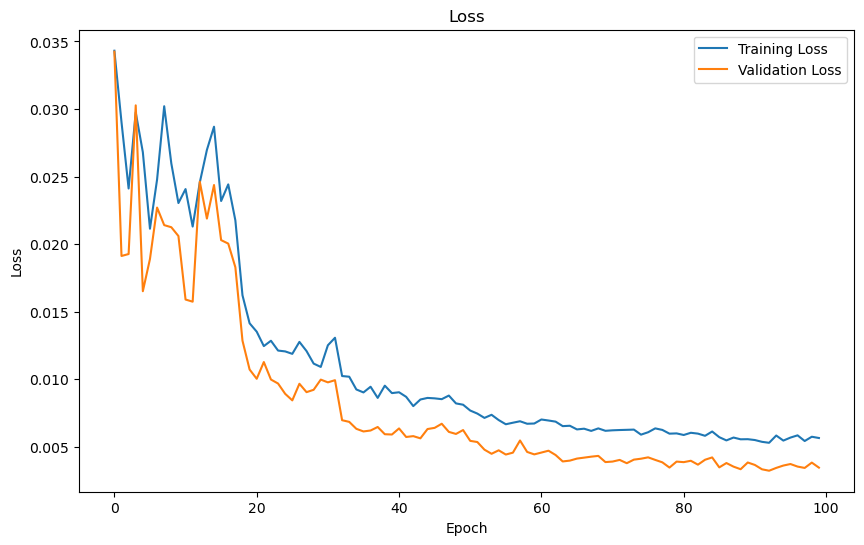

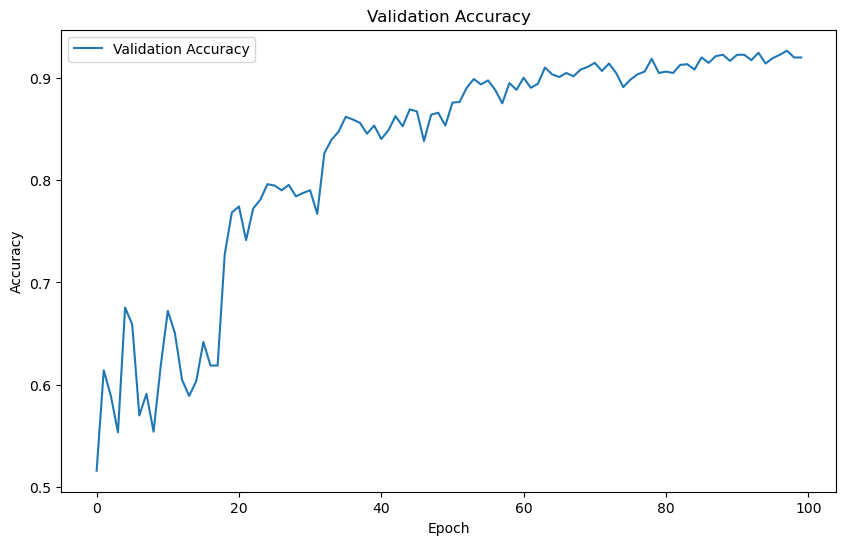

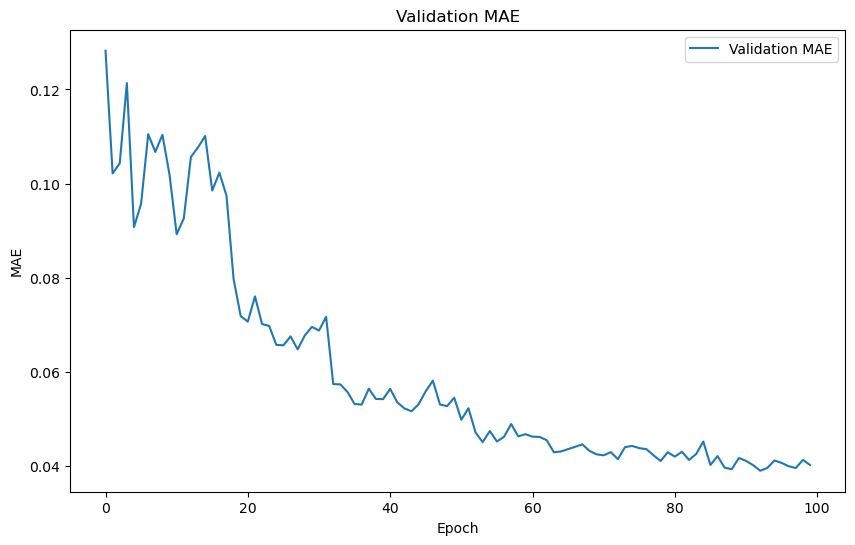

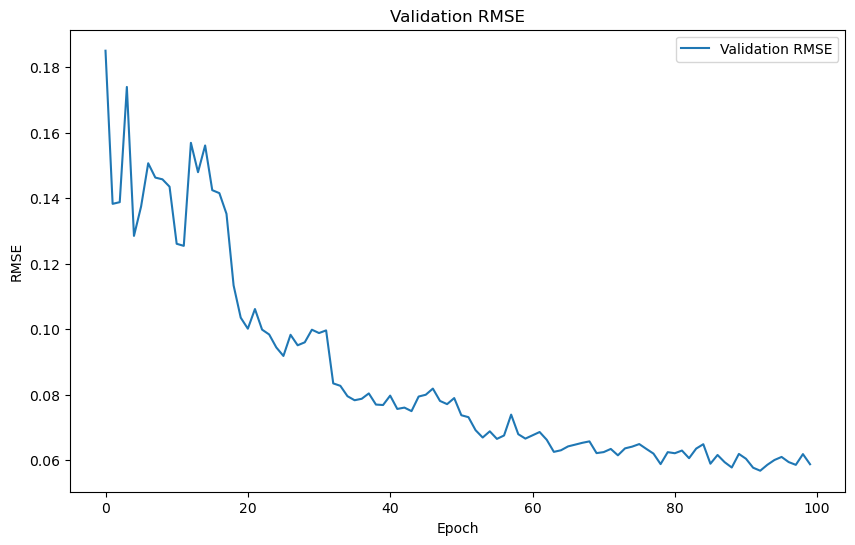

In [93]:
# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# Plot Validation MAE
plt.figure(figsize=(10, 6))
plt.plot(valid_mae, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Validation MAE')
plt.legend()
plt.show()

# Plot Validation RMSE
plt.figure(figsize=(10, 6))
plt.plot(valid_rmse, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Validation RMSE')
plt.legend()
plt.show()


# Save the Model

In [107]:
torch.save(model.state_dict(), 'model.pth')
print("Model saved as 'model.pth'")


Model saved as 'model.pth'


# Testing (need new dataset, 3&5 crashed )

In [44]:
new_data_dir = r"C:\Users\User\OneDrive\Desktop\AV Lab\logging6\logging"
new_log_file_path = os.path.join(new_data_dir, "logging_data", "log_file_0.txt")
new_image_base_path = os.path.join(new_data_dir, "image_data")


with open(new_log_file_path, 'r') as file:
    log_file_content = file.read()

log_lines = log_file_content.strip().split('\n')
new_data = []
skipped_lines = 0

for line in log_lines:
    parts = line.split()
    if len(parts) == 5 and parts[0] != 'Time':
        front_image = parts[1]
        left_image = parts[2]
        right_image = parts[3]
        steering_angle = float(parts[4])
        new_data.append([front_image, left_image, right_image, steering_angle])
    else:
        skipped_lines += 1

# Create a pandas DataFrame
new_df = pd.DataFrame(new_data, columns=['Front Image', 'Left Image', 'Right Image', 'Steering Angle'])

# Normalize and standardize steering angles
new_steering_angles = new_df['Steering Angle'].values

# Normalization (to [-1, 1])
scaler = MinMaxScaler(feature_range=(-1, 1))
new_steering_angles = scaler.fit_transform(new_steering_angles.reshape(-1, 1))

# Standardization (Z-score scaling)
standardizer = StandardScaler()
new_steering_angles = standardizer.fit_transform(new_steering_angles)

# Update the DataFrame
new_df['Steering Angle'] = new_steering_angles


In [46]:
new_dataset = DrivingDataset(new_df, img_dir=new_image_base_path, transform=transform)
new_loader = DataLoader(new_dataset, batch_size=100, shuffle=False, collate_fn=custom_collate)


In [48]:
model = NvidiaModel().to(device)
model.load_state_dict(torch.load('model.pth'))
model.eval()  # Set the model to evaluation mode


C:\Users\User\AppData\Local\Temp\ipykernel_18244\1850997521.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


NvidiaModel(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1152, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)

In [50]:
def evaluate_model(model, data_loader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_targets = []
    total_loss = 0.0
    criterion = nn.MSELoss()  # Same loss function used during training

    with torch.no_grad():
        for images, steering_angles in data_loader:
            if images is None or steering_angles is None:
                continue
                
            images, steering_angles = images.to(device), steering_angles.to(device).float()
            outputs = model(images).squeeze()  # Forward pass
            loss = criterion(outputs, steering_angles)
            total_loss += loss.item() * images.size(0)

            # Store predictions and targets
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(steering_angles.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(data_loader.dataset)
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))

    print(f'Test Loss: {avg_loss:.4f}')
    print(f'Test MAE: {mae:.4f}')
    print(f'Test RMSE: {rmse:.4f}')

    return all_targets, all_predictions  # Return the values

# Run the evaluation
all_targets, all_predictions = evaluate_model(model, new_loader)


Test Loss: 0.0027
Test MAE: 0.0354
Test RMSE: 0.0515


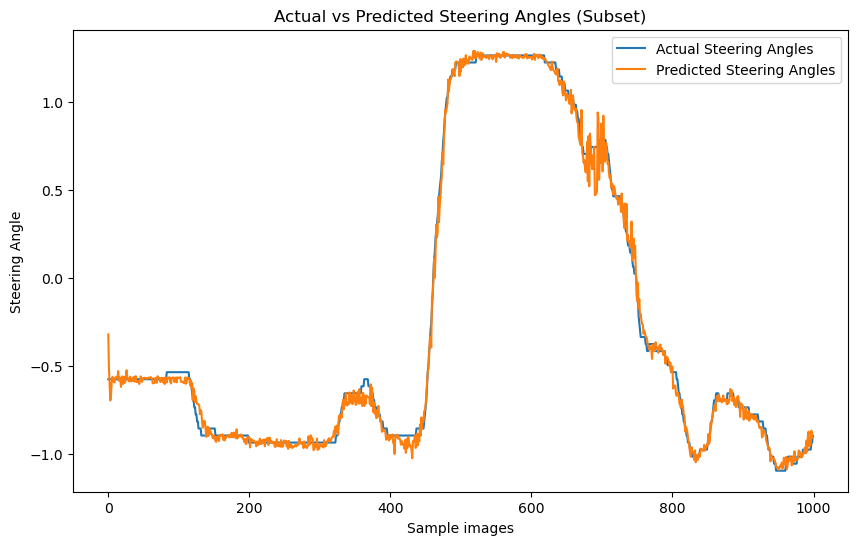

In [51]:
subset_size = 1000
plt.figure(figsize=(10, 6))
plt.plot(all_targets[:subset_size], label='Actual Steering Angles')
plt.plot(all_predictions[:subset_size], label='Predicted Steering Angles')
plt.legend()
plt.xlabel('Sample images')
plt.ylabel('Steering Angle')
plt.title('Actual vs Predicted Steering Angles (Subset)')
plt.show()
